In [46]:
# import libraries
import pandas as pd
import re
import nltk
import numpy as np

import sqlite3
from sqlalchemy import create_engine

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem.wordnet import WordNetLemmatizer

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.multioutput import MultiOutputClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, f1_score, log_loss
from sklearn.preprocessing import MultiLabelBinarizer

from scipy import sparse

import matplotlib.pyplot as plt

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [47]:
from google.colab import drive
drive.mount("/content/gdrive")

gpath = "/content/gdrive/MyDrive/Colab Notebooks/MLP_Disaster/"

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [48]:
# load MLSMOTE
import sys
sys.path.append(gpath)
import MLSMOTE

In [49]:
# load data from database
# engine = create_engine('sqlite:///InsertDatabaseName.db')
conn = sqlite3.connect(gpath + 'InsertDatabaseName.db')
query = 'SELECT * FROM InsertTableName'
df = pd.read_sql(query, con=conn)
X = df['message']
Y = df.iloc[:,4:]

In [50]:
# split into train an test sets
X_train, X_test, y_train, y_test = train_test_split(X, Y)

In [51]:
def tokenize(text):
    # find urls and replace them with 'urlplaceholder'
    url_regex = 'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+'
    text = re.sub(url_regex, 'urlplaceholder', text)
    
    # normalize case and remove punctuation
    text = re.sub(r"[^a-zA-Z0-9]", " ", text.lower())
    
    # tokenize text
    tokens = word_tokenize(text)
    
    # lemmatize and remove stop words
    stop_words = stopwords.words("english")
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]
    
    return tokens

## MLSMOTE

In [52]:
# initialize vectorizer and tfidt transformer
vect = CountVectorizer(tokenizer=tokenize)
tfidf = TfidfTransformer()

In [53]:
# vectorize and generate tfidf of trainings data
X_train_counts = vect.fit_transform(X_train)
X_train_tfidf_matrix = tfidf.fit_transform(X_train_counts)

# convert matrix into dataframe
X_train_tfidf = pd.DataFrame.sparse.from_spmatrix(X_train_tfidf_matrix)

# Getting minority samples of the dataframe
X_sub, y_sub = MLSMOTE.get_minority_samples(X_train_tfidf, y_train)

# Generating synthetic samples based on the minority samples
X_res, y_res = MLSMOTE.MLSMOTE(X_sub, y_sub, 500)

/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_base.py:501: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


### concatenate resample data to train data

In [54]:
X_con = pd.concat([X_train_tfidf, X_res], ignore_index=True)
print(X_con.shape)
y_con = pd.concat([y_train, y_res], ignore_index=True)
print(y_con.shape)

(20161, 26752)
(20161, 35)


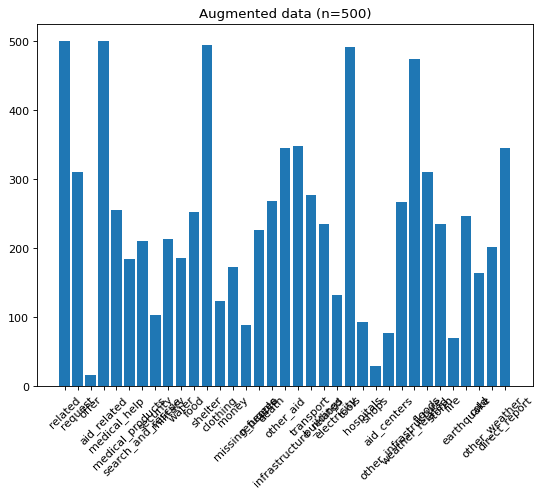

In [56]:
plt.figure(figsize=(8, 6), dpi=80)
plt.xticks(rotation=45)
plt.bar(y_res.sum(axis=0).index, y_res.sum(axis=0).values)
plt.title('Augmented data (n=500)')

plt.show()

## Fit Model


In [57]:
pipeline = Pipeline([
    ('clf', MultiOutputClassifier(RandomForestClassifier()))
])

model = pipeline
model.fit(X_con, y_con)

Pipeline(steps=[('clf',
                 MultiOutputClassifier(estimator=RandomForestClassifier()))])

## test Model

In [58]:
# vectorize and generate tfidf of trainings data
X_test_counts = vect.transform(X_test)
X_test_tfidf_matrix = tfidf.transform(X_test_counts)

# convert matrix into dataframe
X_test_tfidf = pd.DataFrame.sparse.from_spmatrix(X_test_tfidf_matrix)

In [59]:
y_pred = model.predict(X_test_tfidf)

In [60]:
# convert ndarray to df
y_pred_df = pd.DataFrame(y_pred, columns=y_con.columns)

In [61]:
# transform iterable of iterables to a multilabel format
m = MultiLabelBinarizer().fit(np.array(y_test))

In [62]:
print(classification_report(y_test, y_pred, target_names=y_test.keys()))

                        precision    recall  f1-score   support

               related       0.84      0.96      0.89      4992
               request       0.83      0.50      0.62      1131
                 offer       0.00      0.00      0.00        27
           aid_related       0.75      0.72      0.73      2702
          medical_help       0.57      0.09      0.16       523
      medical_products       0.71      0.11      0.19       336
     search_and_rescue       0.71      0.17      0.27       160
              security       0.00      0.00      0.00       142
              military       0.57      0.08      0.13       212
                 water       0.91      0.39      0.55       405
                  food       0.86      0.65      0.74       737
               shelter       0.79      0.47      0.59       579
              clothing       0.75      0.12      0.21       120
                 money       1.00      0.02      0.04       135
        missing_people       0.50      

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [64]:
# print accuracy, Note: Accuracy does not work well on imbalanced data sets!
print(f"Accuracy of Model: {model.score(X_test_tfidf,np.array(y_test))} - bad metrics (!)")

# print f1 score
print("F1 Score: ", f1_score(m.transform(np.array(y_test)), m.transform(y_pred), average='macro'))

Accuracy of Model: 0.27525175465364665 - bad metrics (!)
F1 Score:  0.9466137319009809
